Notebook 3: Predicting Animal outcomes

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from plotnine import *
import itertools
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn import tree

%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Need to drop those outcomes that have too few observations otherwise the models won't take

In [3]:
df.outcome_type.value_counts()
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]

Gather up the features we want, encode them, and split the data

In [4]:
c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'outcome_type', 'intake_type_clean', 'color_clean', 'intake_times', 'days_spent']]

c_data = c_data.dropna()
y = c_data['outcome_type']
x = c_data.drop('outcome_type', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99, stratify=y)

In [6]:
c_data.outcome_type.value_counts()

ADOPTION    13862
FOSTER      10376
RTO          4827
EUTH         3298
TRANSFER     1816
RTF           966
DIED          275
EUTH VET      158
Name: outcome_type, dtype: int64

In [7]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([13862,   275,  3298,   158, 10376,   966,  4827,  1816]))

Fit a simple decision tree classifier and inspect the performance

In [8]:
d_tree = DecisionTreeClassifier(random_state=99)
d_tree.fit(x_train, y_train)
y_pred_tree = d_tree.predict(x_test)
target_names = ['ADOPTION', 'DIED', 'EUTH', 'EUTH VET', 'FOSTER', 'RTF', 'RTO', 'TRANSFER']
print(classification_report(y_test, y_pred_tree, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.79      0.82      0.81      4575
        DIED       0.15      0.12      0.13        91
        EUTH       0.49      0.48      0.49      1088
    EUTH VET       0.16      0.12      0.13        52
      FOSTER       0.78      0.78      0.78      3424
         RTF       0.64      0.59      0.62       319
         RTO       0.69      0.69      0.69      1593
    TRANSFER       0.39      0.35      0.37       599

    accuracy                           0.72     11741
   macro avg       0.51      0.49      0.50     11741
weighted avg       0.72      0.72      0.72     11741



Fit a random forest, performs slightly better than the decision tree

In [9]:
rf = RandomForestClassifier(random_state=99)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.81      0.84      0.83      4575
        DIED       0.23      0.08      0.11        91
        EUTH       0.57      0.51      0.54      1088
    EUTH VET       0.25      0.12      0.16        52
      FOSTER       0.78      0.81      0.80      3424
         RTF       0.68      0.66      0.67       319
         RTO       0.73      0.74      0.74      1593
    TRANSFER       0.48      0.40      0.44       599

    accuracy                           0.75     11741
   macro avg       0.57      0.52      0.54     11741
weighted avg       0.74      0.75      0.75     11741



Inspect feature importance

<AxesSubplot:xlabel='feature', ylabel='importance'>

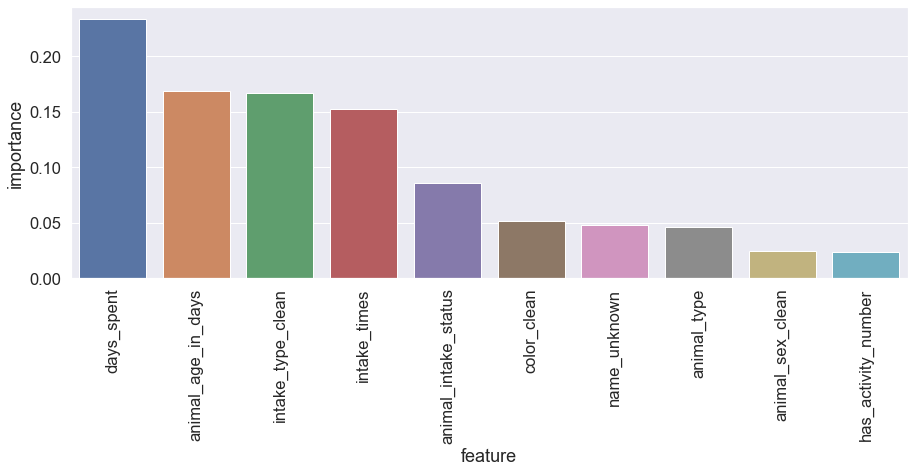

In [10]:
feature_importances = rf.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': x_train.columns}, 
                           index=x_train.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

Tune the hyper parameters of the random forst and cross validate it

In [11]:
criterion = ['gini', 'entropy']
components = [175, 200, 225]
estimators = [100, 250, 500]
k = [10, 15, 20]
cv = StratifiedKFold(3)

In [12]:
rf = RandomForestClassifier(class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_gridcv = GridSearchCV(estimator=rf, param_grid=dict(n_estimators=estimators, 
                                                     criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

rf_gridcv.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              oob_score=True),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 250, 500]},
             return_train_score=True, scoring='accuracy')

In [13]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,6.740449,0.017363,0.600441,0.019551,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.733325,0.736219,0.725991,0.731845,0.004305,1,0.917438,0.921276,0.920841,0.919851,0.001716
1,3.323716,0.016171,0.296215,0.004541,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.732318,0.737478,0.725488,0.731761,0.004911,2,0.917563,0.921276,0.920841,0.919893,0.001657
4,3.418677,0.007962,0.274808,0.000982,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.732192,0.736219,0.726746,0.731719,0.003882,3,0.918004,0.920962,0.920778,0.919914,0.001353
5,6.858244,0.040406,0.555920,0.007211,entropy,500,"{'criterion': 'entropy', 'n_estimators': 500}",0.732570,0.735842,0.726621,0.731677,0.003817,4,0.917563,0.920836,0.920400,0.919600,0.001451
0,1.394287,0.028246,0.123560,0.000936,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.732444,0.735842,0.726369,0.731552,0.003919,5,0.918004,0.920206,0.921596,0.919935,0.001479


Performs slightly worse but is likely less prone to overfitting from the cross validation

In [14]:
rf_grid_pred = rf_gridcv.predict(x_test)
print(classification_report(y_test, rf_grid_pred, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.82      0.81      0.82      4575
        DIED       0.14      0.20      0.17        91
        EUTH       0.53      0.50      0.52      1088
    EUTH VET       0.19      0.31      0.23        52
      FOSTER       0.79      0.79      0.79      3424
         RTF       0.64      0.70      0.67       319
         RTO       0.72      0.73      0.73      1593
    TRANSFER       0.42      0.41      0.41       599

    accuracy                           0.74     11741
   macro avg       0.53      0.56      0.54     11741
weighted avg       0.74      0.74      0.74     11741



Normalized confusion matrix


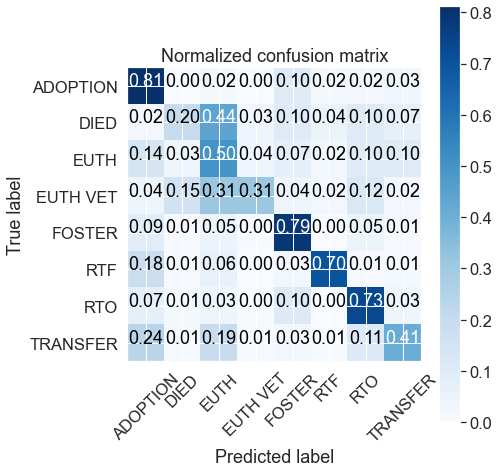

In [15]:
plt.figure(figsize=(7, 7))
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)
plot_confusion_matrix(rf_cnf_mat, classes=target_names, normalize=True, title='Normalized confusion matrix')

Seems to be conflating DIED, EUTH, and EUTH VET with one another so let's group them together since they're similar outcomes qualitatively

In [16]:
df['outcome_type_clean'] = df['outcome_type']
df.loc[df['outcome_type_clean'].isin(['DIED', 'EUTH', 'EUTH VET']), 'outcome_type_clean'] = 'DIED'

c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'outcome_type_clean', 'intake_type_clean', 'color_clean', 'intake_times', 'days_spent']]

c_data = c_data.dropna()
y = c_data['outcome_type_clean']
x = c_data.drop('outcome_type_clean', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99, stratify=y)
target_names = ['ADOPTION', 'DIED', 'FOSTER', 'RTF', 'RTO', 'TRANSFER']

rf = RandomForestClassifier(class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_gridcv = GridSearchCV(estimator=rf, param_grid=dict(n_estimators=estimators, 
                                                     criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

rf_gridcv.fit(x_train, y_train)

rf_grid_pred = rf_gridcv.predict(x_test)
print(classification_report(y_test, rf_grid_pred, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.82      0.81      0.82      4575
        DIED       0.60      0.62      0.61      1231
      FOSTER       0.79      0.79      0.79      3424
         RTF       0.66      0.74      0.69       319
         RTO       0.73      0.72      0.73      1593
    TRANSFER       0.42      0.41      0.41       599

    accuracy                           0.75     11741
   macro avg       0.67      0.68      0.67     11741
weighted avg       0.75      0.75      0.75     11741



Normalized confusion matrix


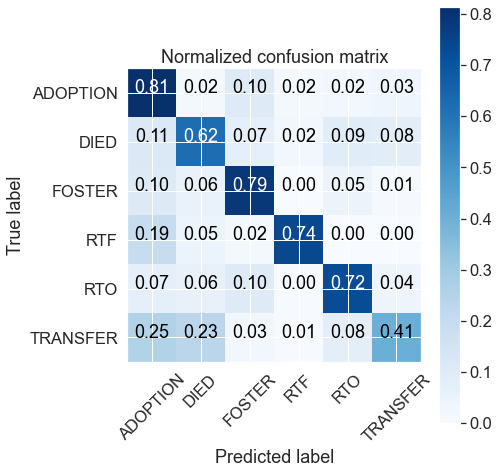

In [18]:
plt.figure(figsize=(7, 7))
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)
plot_confusion_matrix(rf_cnf_mat, classes=target_names, normalize=True, title='Normalized confusion matrix')

This cross validated model improves by 2 points on the test set